# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, all transcripts, no middle-exclusion train, no middle-exclusion test, -1 threshold, learning module, cross-validation.

In [9]:
SEED = 45
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-05-01 21:24:35.755794


In [10]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP_NoNo'
SAVE_DESCRIM_FILENAME = None # 'GMM_NoNo'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [11]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [12]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.all_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.all_lncRNA_transcripts.csv'

In [13]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [14]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-05-01 21:24:37.175930
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_lncRNA_transcripts.csv
Loaded 20943 sequences.

Training # 1 1
2023-05-01 21:25:07.419975
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 10048:7157 58.40%
Computed class weights: {0: 1.201970099203577, 1: 0.856140525477707}
Valid 1:0 2185:1553 58.45%
FIT


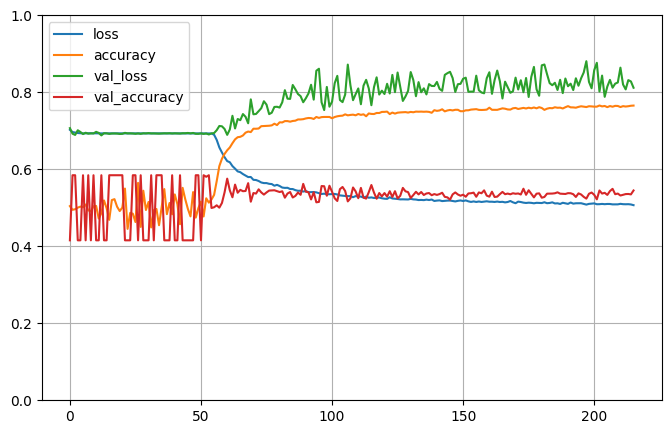


Testing # 1 1
2023-05-01 21:35:07.347995
PREDICT
Test 1:0 2185:1553 58.45%
Predict 1:0 2591:1147 69.32%
Test sizes (3738, 1025) (3738,)
Distrib of scores: 0.59724045 mean 0.22049038 std
Range of scores: 0.005230402 to 0.9371906
Score threshold 0.5
Confusion matrix
 [[ 526 1027]
 [ 621 1564]]
Normalized matrix
 [[0.14071696 0.27474585]
 [0.16613162 0.41840556]]
Extreme scores correct, pos:neg 1085 293
Extreme scores incorrect pos:neg 660 279


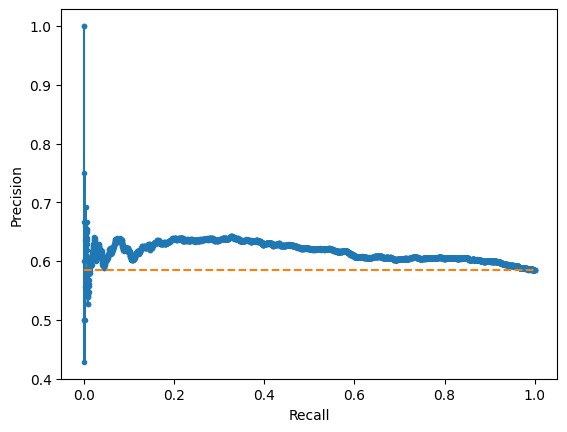

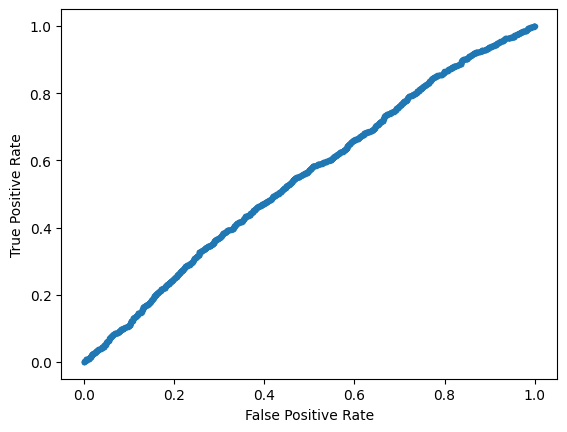

Accuracy: 55.91% Precision: 60.36% Recall: 71.58%
F1: 65.49% MCC: 0.0582
AUPRC: 61.65% AUROC: 55.01%
 accuracy [55.912252541466025]
 precision [60.36279428791972]
 recall [71.57894736842105]
 F1 [65.49413735343383]
 MCC [0.058224129035270154]
 AUPRC [61.65335114580881]
 AUROC [55.01432968742862]

Training # 1 2
2023-05-01 21:35:08.237435
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9502:6343 59.97%
Computed class weights: {0: 1.2490146618319407, 1: 0.8337718375078931}
Valid 1:0 2731:2367 53.57%
FIT


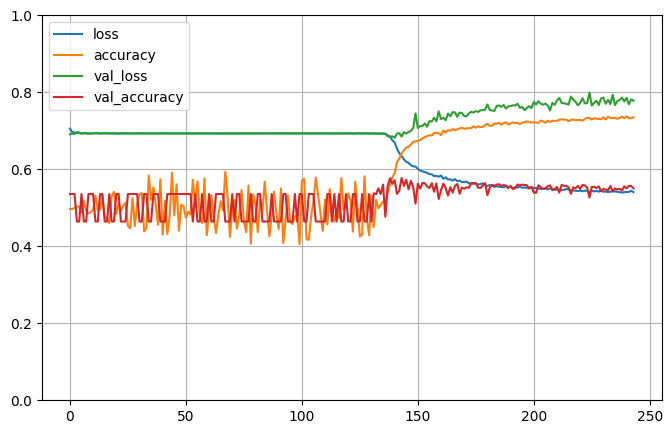


Testing # 1 2
2023-05-01 21:45:46.834025
PREDICT
Test 1:0 2731:2367 53.57%
Predict 1:0 3113:1985 61.06%
Test sizes (5098, 1025) (5098,)
Distrib of scores: 0.5338353 mean 0.122570544 std
Range of scores: 0.08476114 to 0.8928113
Score threshold 0.5
Confusion matrix
 [[1099 1268]
 [ 886 1845]]
Normalized matrix
 [[0.21557474 0.24872499]
 [0.17379364 0.36190663]]
Extreme scores correct, pos:neg 558 215
Extreme scores incorrect pos:neg 327 126


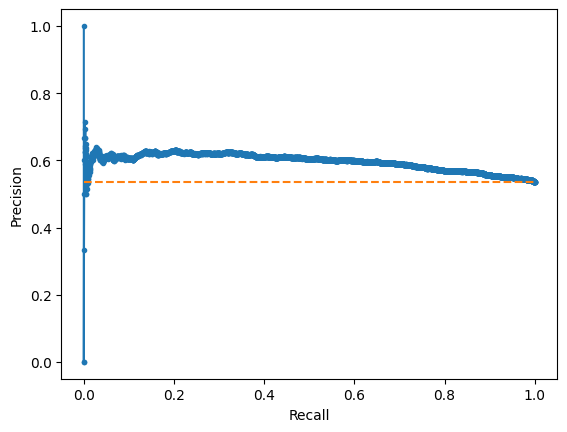

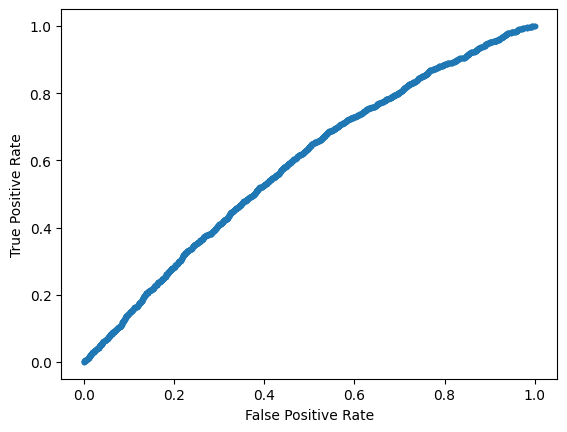

Accuracy: 57.75% Precision: 59.27% Recall: 67.56%
F1: 63.14% MCC: 0.1431
AUPRC: 59.61% AUROC: 58.78%
 accuracy [57.74813652412711]
 precision [59.26758753613878]
 recall [67.55767118271694]
 F1 [63.14168377823409]
 MCC [0.1430665386336689]
 AUPRC [59.61429254811452]
 AUROC [58.77577647121248]

Training # 1 3
2023-05-01 21:45:47.749394
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9917:6983 58.68%
Computed class weights: {0: 1.2100816268079622, 1: 0.8520721992538066}
Valid 1:0 2316:1727 57.28%
FIT


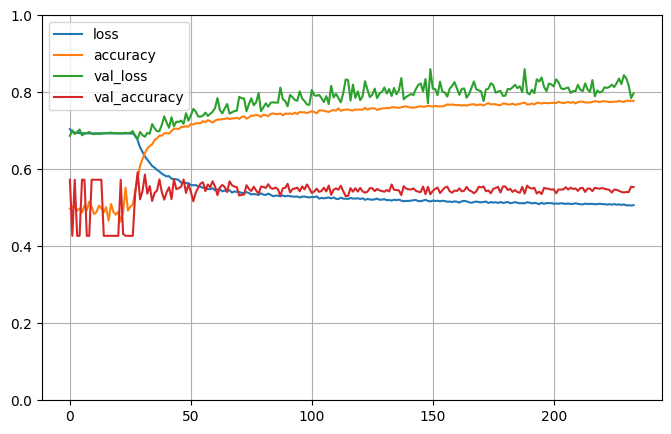


Testing # 1 3
2023-05-01 21:56:31.569487
PREDICT
Test 1:0 2316:1727 57.28%
Predict 1:0 2985:1058 73.83%
Test sizes (4043, 1025) (4043,)
Distrib of scores: 0.6187249 mean 0.23481463 std
Range of scores: 0.057503045 to 0.90114564
Score threshold 0.5
Confusion matrix
 [[ 504 1223]
 [ 554 1762]]
Normalized matrix
 [[0.12465991 0.30249814]
 [0.13702696 0.43581499]]
Extreme scores correct, pos:neg 1407 336
Extreme scores incorrect pos:neg 934 347


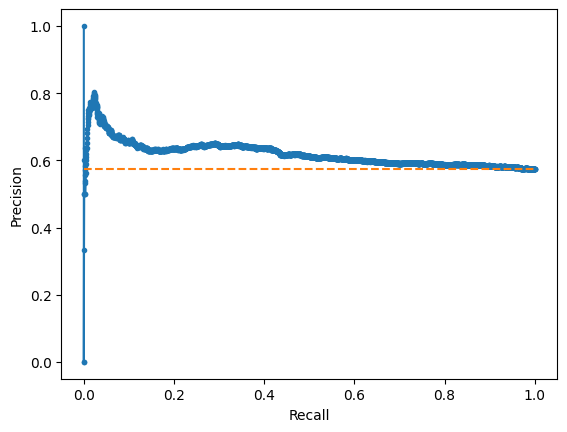

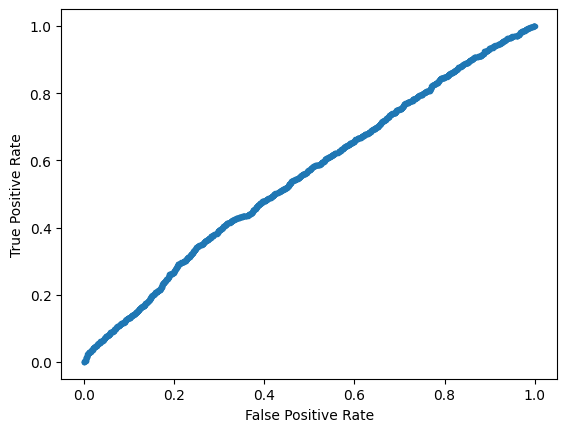

Accuracy: 56.05% Precision: 59.03% Recall: 76.08%
F1: 66.48% MCC: 0.0592
AUPRC: 61.90% AUROC: 55.34%
 accuracy [56.047489488003954]
 precision [59.0284757118928]
 recall [76.07944732297064]
 F1 [66.47802301452556]
 MCC [0.059228949648914224]
 AUPRC [61.904379253897886]
 AUROC [55.34274546394609]

Training # 1 4
2023-05-01 21:56:32.410232
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9895:7159 58.02%
Computed class weights: {0: 1.191088140801788, 1: 0.8617483577564427}
Valid 1:0 2338:1551 60.12%
FIT


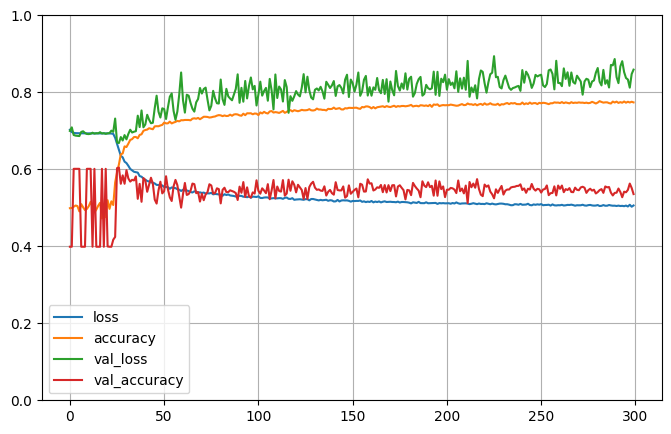


Testing # 1 4
2023-05-01 22:10:56.984848
PREDICT
Test 1:0 2338:1551 60.12%
Predict 1:0 1960:1929 50.40%
Test sizes (3889, 1025) (3889,)
Distrib of scores: 0.49558172 mean 0.28396276 std
Range of scores: 0.113163926 to 0.8473152
Score threshold 0.5
Confusion matrix
 [[ 837  714]
 [1092 1246]]
Normalized matrix
 [[0.21522242 0.18359475]
 [0.28079198 0.32039085]]
Extreme scores correct, pos:neg 982 647
Extreme scores incorrect pos:neg 547 832


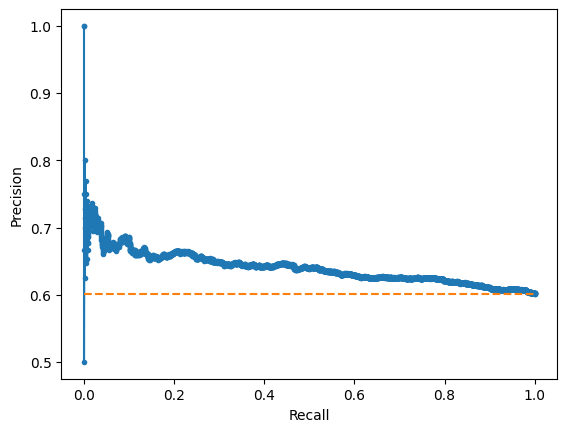

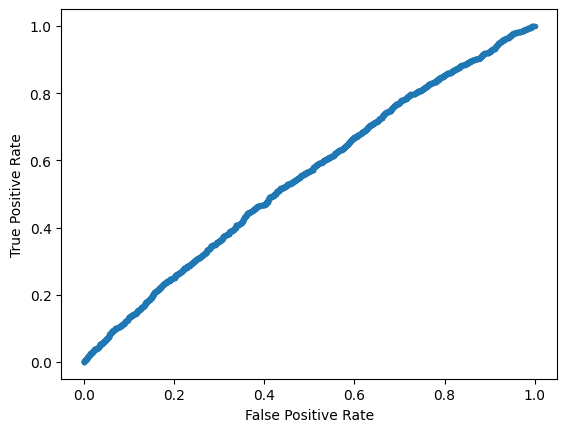

Accuracy: 53.56% Precision: 63.57% Recall: 53.29%
F1: 57.98% MCC: 0.0711
AUPRC: 64.02% AUROC: 55.13%
 accuracy [53.561326819233734]
 precision [63.57142857142857]
 recall [53.293413173652695]
 F1 [57.980456026058626]
 MCC [0.07108642656466399]
 AUPRC [64.01884823701626]
 AUROC [55.13477052526613]

Training # 1 5
2023-05-01 22:10:57.825696
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9570:7198 57.07%
Computed class weights: {0: 1.1647679911086413, 1: 0.8760710553814002}
Valid 1:0 2663:1512 63.78%
FIT


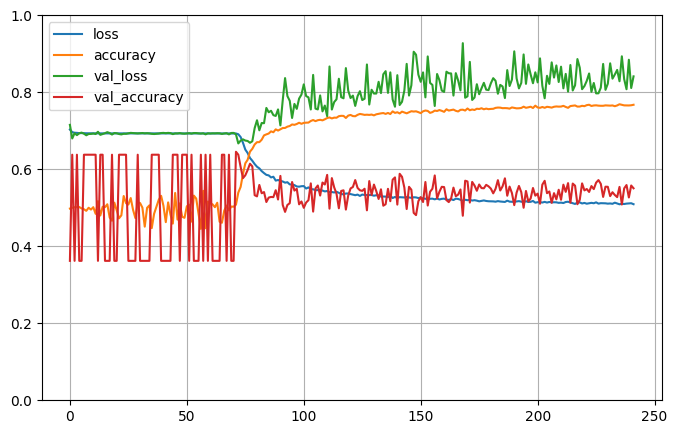


Testing # 1 5
2023-05-01 22:22:21.503087
PREDICT
Test 1:0 2663:1512 63.78%
Predict 1:0 3210:965 76.89%
Test sizes (4175, 1025) (4175,)
Distrib of scores: 0.63962 mean 0.2148759 std
Range of scores: 0.018973159 to 0.952921
Score threshold 0.5
Confusion matrix
 [[ 379 1133]
 [ 586 2077]]
Normalized matrix
 [[0.09077844 0.27137725]
 [0.14035928 0.49748503]]
Extreme scores correct, pos:neg 1573 212
Extreme scores incorrect pos:neg 827 305


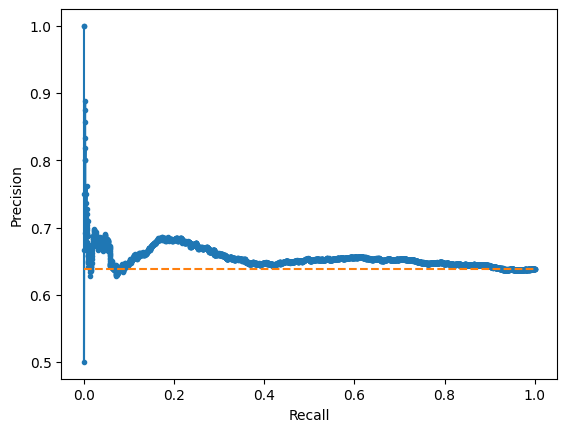

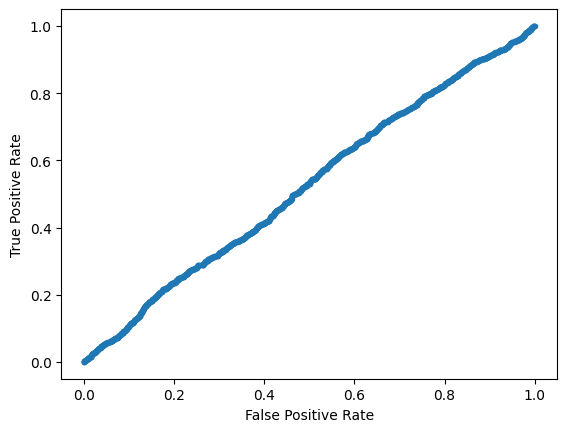

Accuracy: 58.83% Precision: 64.70% Recall: 77.99%
F1: 70.73% MCC: 0.0349
AUPRC: 65.47% AUROC: 52.40%
 accuracy [58.82634730538923]
 precision [64.70404984423675]
 recall [77.99474277131056]
 F1 [70.73046143367955]
 MCC [0.034897286382581764]
 AUPRC [65.46696306345909]
 AUROC [52.39731913126581]

Training # 2 1
2023-05-01 22:22:22.970718
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9889:6553 60.14%
Computed class weights: {0: 1.2545399053868458, 1: 0.8313277378905854}
Valid 1:0 2344:2157 52.08%
FIT


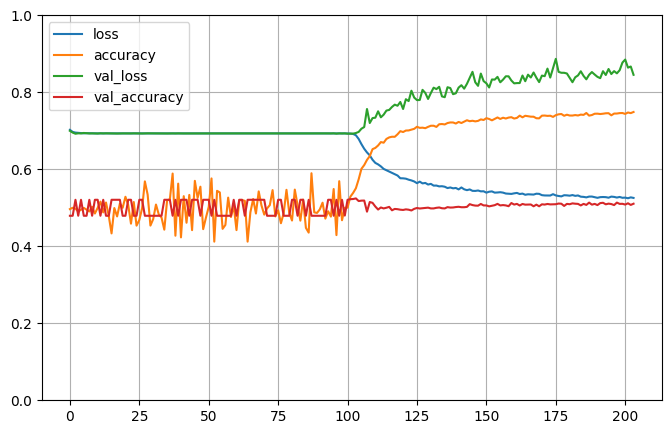


Testing # 2 1
2023-05-01 22:31:33.650242
PREDICT
Test 1:0 2344:2157 52.08%
Predict 1:0 3965:536 88.09%
Test sizes (4501, 1025) (4501,)
Distrib of scores: 0.539043 mean 0.032008473 std
Range of scores: 0.43693146 to 0.64851516
Score threshold 0.5
Confusion matrix
 [[ 276 1881]
 [ 260 2084]]
Normalized matrix
 [[0.06131971 0.41790713]
 [0.05776494 0.46300822]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


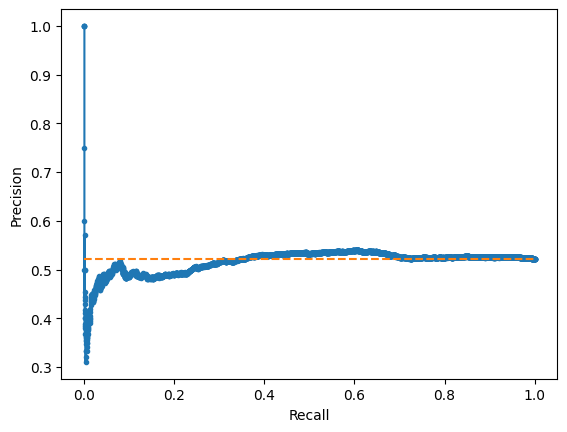

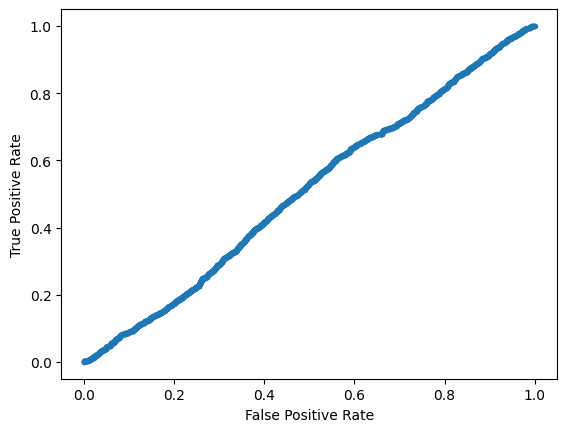

Accuracy: 52.43% Precision: 52.56% Recall: 88.91%
F1: 66.06% MCC: 0.0263
AUPRC: 51.67% AUROC: 50.83%
 accuracy [52.4327927127305]
 precision [52.55989911727617]
 recall [88.90784982935153]
 F1 [66.06435251228405]
 MCC [0.026273402878638046]
 AUPRC [51.666857654865495]
 AUROC [50.83217827186982]

Training # 2 2
2023-05-01 22:31:34.654830
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9917:7231 57.83%
Computed class weights: {0: 1.1857281150601577, 1: 0.8645759806393063}
Valid 1:0 2316:1479 61.03%
FIT


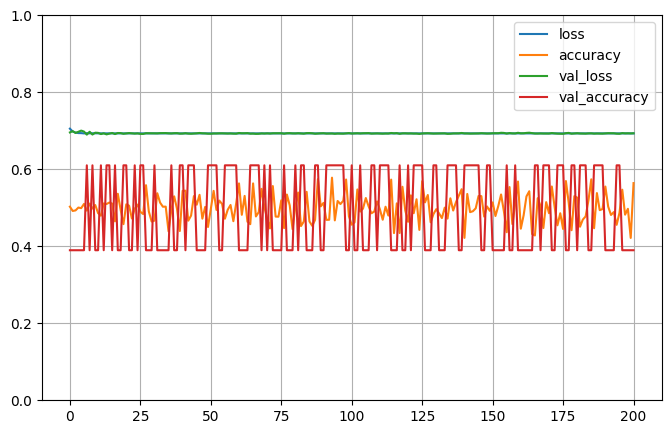


Testing # 2 2
2023-05-01 22:40:33.896060
PREDICT
Test 1:0 2316:1479 61.03%
Predict 1:0 3795:0 100.00%
Test sizes (3795, 1025) (3795,)
Distrib of scores: 0.5007753 mean 0.0 std
Range of scores: 0.5007753 to 0.5007753
Score threshold 0.5
Confusion matrix
 [[   0 1479]
 [   0 2316]]
Normalized matrix
 [[0.         0.38972332]
 [0.         0.61027668]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


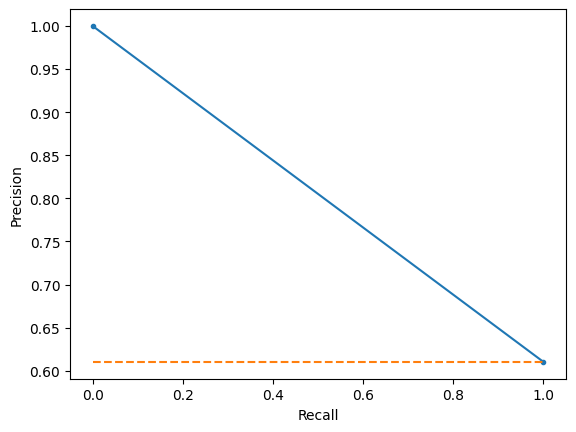

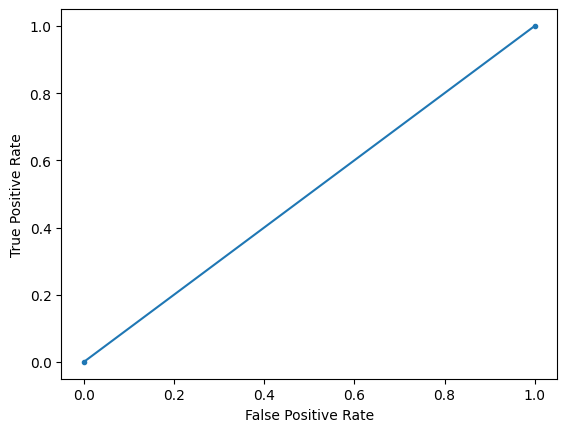

Accuracy: 61.03% Precision: 61.03% Recall: 100.00%
F1: 75.80% MCC: 0.0000
AUPRC: 80.51% AUROC: 50.00%
 accuracy [61.027667984189726]
 precision [61.027667984189726]
 recall [100.0]
 F1 [75.79774177712322]
 MCC [0.0]
 AUPRC [80.51383399209486]
 AUROC [50.0]

Training # 2 3
2023-05-01 22:40:34.731106
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9841:7425 57.00%
Computed class weights: {0: 1.1626936026936028, 1: 0.8772482471293568}
Valid 1:0 2392:1285 65.05%
FIT


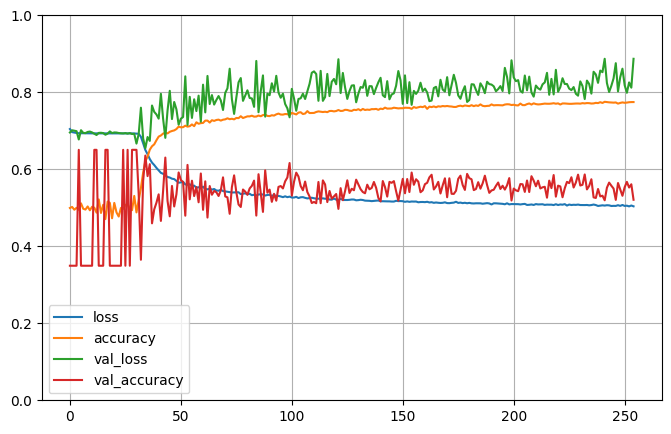


Testing # 2 3
2023-05-01 22:52:58.489233
PREDICT
Test 1:0 2392:1285 65.05%
Predict 1:0 2554:1123 69.46%
Test sizes (3677, 1025) (3677,)
Distrib of scores: 0.6080734 mean 0.24197073 std
Range of scores: 0.044713948 to 0.8593639
Score threshold 0.5
Confusion matrix
 [[ 453  832]
 [ 670 1722]]
Normalized matrix
 [[0.12319826 0.22627142]
 [0.18221376 0.46831656]]
Extreme scores correct, pos:neg 1372 287
Extreme scores incorrect pos:neg 659 417


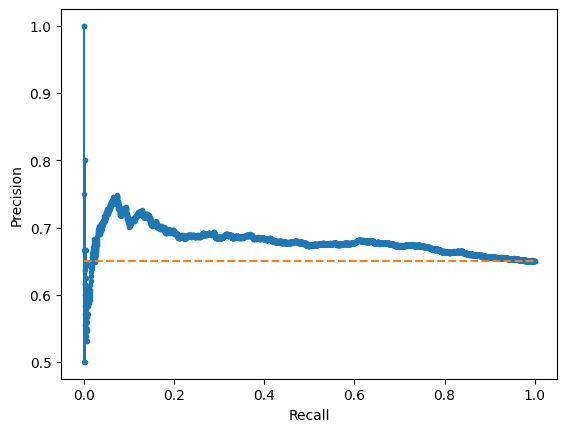

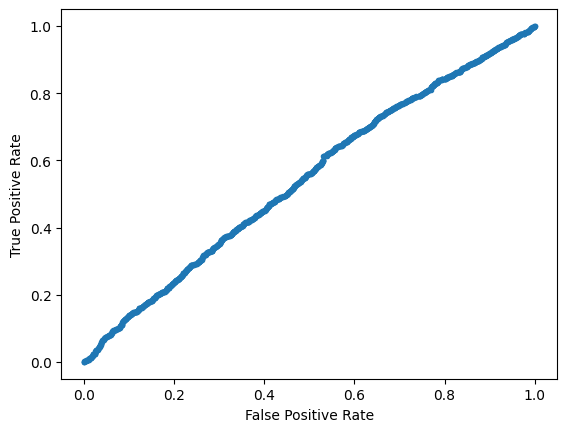

Accuracy: 59.15% Precision: 67.42% Recall: 71.99%
F1: 69.63% MCC: 0.0750
AUPRC: 67.94% AUROC: 54.37%
 accuracy [59.15148218656513]
 precision [67.42364917776038]
 recall [71.98996655518395]
 F1 [69.6320258794986]
 MCC [0.07497964971295575]
 AUPRC [67.9423207643295]
 AUROC [54.3682573559075]

Training # 2 4
2023-05-01 22:52:59.402551
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 10008:6834 59.42%
Computed class weights: {0: 1.2322212467076383, 1: 0.8414268585131894}
Valid 1:0 2225:1876 54.26%
FIT


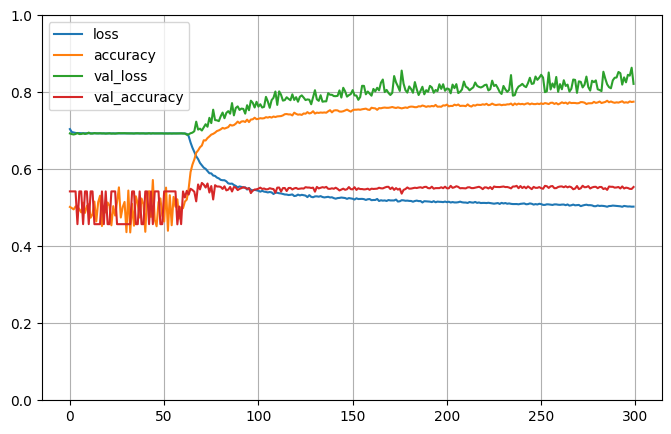


Testing # 2 4
2023-05-01 23:06:18.534528
PREDICT
Test 1:0 2225:1876 54.26%
Predict 1:0 2522:1579 61.50%
Test sizes (4101, 1025) (4101,)
Distrib of scores: 0.5561389 mean 0.26877344 std
Range of scores: 0.085376106 to 0.8719057
Score threshold 0.5
Confusion matrix
 [[ 813 1063]
 [ 766 1459]]
Normalized matrix
 [[0.19824433 0.25920507]
 [0.18678371 0.35576689]]
Extreme scores correct, pos:neg 1200 604
Extreme scores incorrect pos:neg 851 569


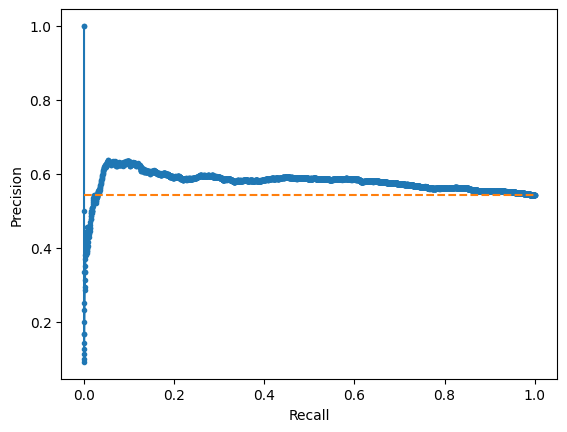

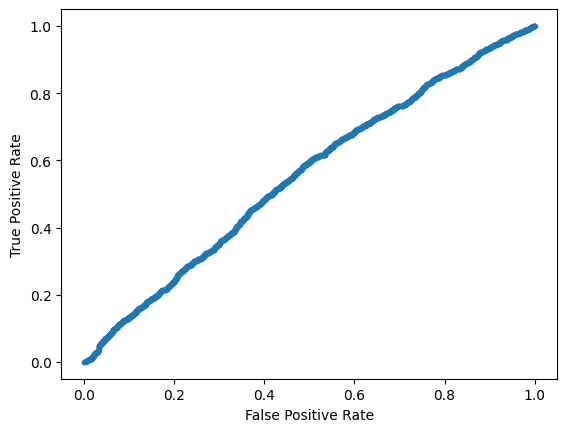

Accuracy: 55.40% Precision: 57.85% Recall: 65.57%
F1: 61.47% MCC: 0.0912
AUPRC: 57.80% AUROC: 55.41%
 accuracy [55.401121677639594]
 precision [57.85091197462332]
 recall [65.57303370786516]
 F1 [61.47040235938488]
 MCC [0.09122033385661565]
 AUPRC [57.797301298796455]
 AUROC [55.40599171078795]

Training # 2 5
2023-05-01 23:06:19.439402
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 9277:6797 57.71%
Computed class weights: {0: 1.1824334265116963, 1: 0.8663361000323381}
Valid 1:0 2956:1913 60.71%
FIT


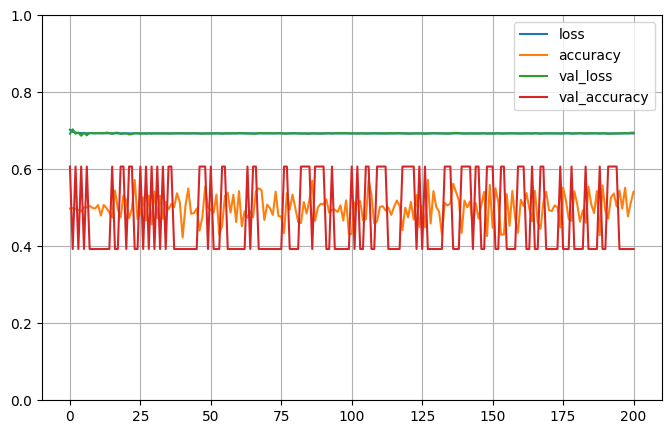


Testing # 2 5
2023-05-01 23:15:00.165938
PREDICT
Test 1:0 2956:1913 60.71%
Predict 1:0 4869:0 100.00%
Test sizes (4869, 1025) (4869,)
Distrib of scores: 0.50096536 mean 5.61958e-08 std
Range of scores: 0.50096524 to 0.5009656
Score threshold 0.5
Confusion matrix
 [[   0 1913]
 [   0 2956]]
Normalized matrix
 [[0.         0.39289382]
 [0.         0.60710618]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


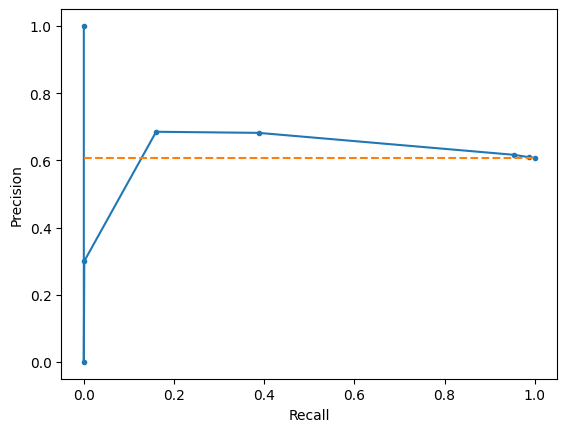

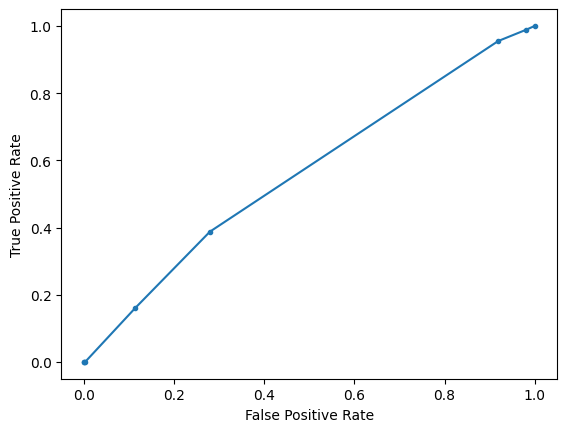

Accuracy: 60.71% Precision: 60.71% Recall: 100.00%
F1: 75.55% MCC: 0.0000
AUPRC: 62.97% AUROC: 56.27%
 accuracy [60.710618196754986]
 precision [60.710618196754986]
 recall [100.0]
 F1 [75.55271565495207]
 MCC [0.0]
 AUPRC [62.966886842030256]
 AUROC [56.26752042679281]
2023-05-01 23:15:01.130753


In [15]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [16]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 57.08% std 2.90
 precision mean 60.65% std 4.07
 recall mean 77.30% std 15.04
 F1 mean 67.23% std 5.78
 MCC mean 0.0559 std 0.0435
 AUPRC mean 63.35% std 7.51
 AUROC mean 54.35% std 2.61
 accuracy [[55.912252541466025], [57.74813652412711], [56.047489488003954], [53.561326819233734], [58.82634730538923], [52.4327927127305], [61.027667984189726], [59.15148218656513], [55.401121677639594], [60.710618196754986]]
 precision [[60.36279428791972], [59.26758753613878], [59.0284757118928], [63.57142857142857], [64.70404984423675], [52.55989911727617], [61.027667984189726], [67.42364917776038], [57.85091197462332], [60.710618196754986]]
 recall [[71.57894736842105], [67.55767118271694], [76.07944732297064], [53.293413173652695], [77.99474277131056], [88.90784982935153], [100.0], [71.98996655518395], [65.57303370786516], [100.0]]
 F1 [[65.49413735343383], [63.14168377823409], [66.47802301452556], [57.980456026058626], [70.73046143367955], [66.06435251228405], [75.79774177712322], 